In [1]:
import sys
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )

#%matplotlib inline
import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

%matplotlib inline

af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
fig_path = '/home/greg/current/NMEG_miscellany/figures/2015_ignite_figs/'

In [2]:
# Years to load
start = 2007
end = 2014
# Sites to load (pulls list of AF sites from plot_nmeg module)
sites = nmegplt.sites

# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2014_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_

In [3]:
# Resample all hourly dataframes in Hourly to daily and add to daily dict
daily = { x : 
         tr.resample_30min_aflx( hourly[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly.keys() }

# Convert this to a pandas panel
d = pd.Panel(daily)


In [4]:
# Make a timeseries plot

nmeg_palette = nmegplt.palette
nmeg_names = nmegplt.names

def plot_tseries(figh, pan, sitelist, var, ylabel, name_y,
                 xlim, ylim,
                 palette=nmeg_palette, names=nmeg_names):
    ax = list()
    for i, site in enumerate(sitelist):
        ax.append(figh.add_subplot(len(sitelist), 1, i+1))
        plt.plot( xlims, [0, 0], ':k')
        plt.plot(pan[site].index, pan[site][var], color=palette[i])
        plt.ylim( ylim )
        plt.xlim( xlim )
        plt.text( dt.datetime( 2007, 2, 1 ), name_y, names[i], size=14  )
        if i < len(sitelist)-1:
            plt.setp( ax[i].get_xticklabels(), visible=False)
        plt.setp( ax[i].get_yticklabels(), fontsize=13)

    for j in (0,2,4):
        ax[j].set_ylabel(ylabel, fontsize=14)
        
    return(figh)

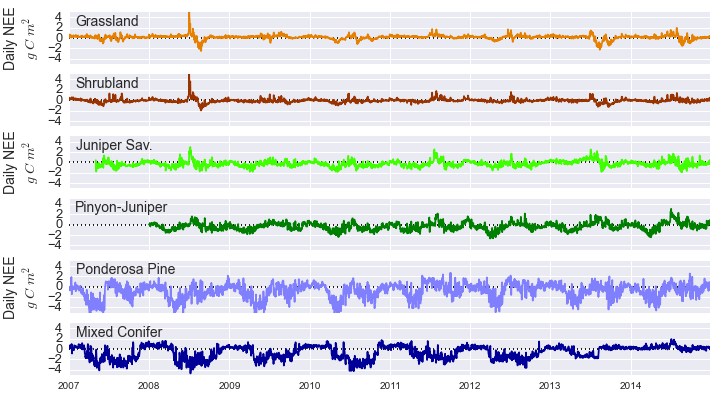

In [5]:

ylims = [ -5, 5 ]
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

fig1 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
fig1 = plot_tseries(fig1, d, sites, 'FC_F_g_int', 'Daily NEE\n$g\ C\ m^2$',
                   2.5, xlims, ylims)

fig1.savefig( fig_path + 'NMEG_daily_FC.svg')
fig1.savefig( fig_path + 'NMEG_daily_FC.png', dpi=200)

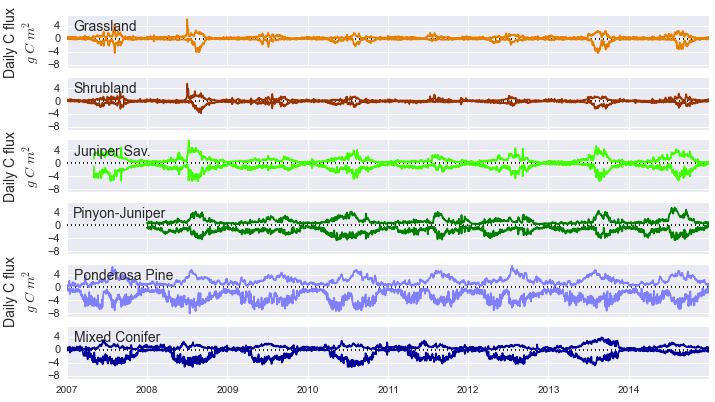

In [6]:
ylims = [ -9, 7 ]

fig2 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = list()
for i, site in enumerate(sites):
    ax.append(fig2.add_subplot(6, 1, i+1))
    plt.plot( xlims, [0, 0], ':k')
    plt.plot(d[site].index, -d[site].GPP_g_int, color=nmeg_palette[i])
    plt.plot(d[site].index, d[site].RECO_g_int, color=nmeg_palette[i])
    plt.ylim( ylims )
    plt.xlim( xlims )
    plt.text( dt.datetime( 2007, 2, 1 ), 2.5, nmegplt.names[i], size=14  )
    if i < len(sites)-1:
        plt.setp( ax[i].get_xticklabels(), visible=False)
    plt.setp( ax[i].get_yticklabels(), fontsize=11)
    ax[i].yaxis.set_ticks(np.arange(-8, 6, 4))

for j in (0,2,4):
    ax[j].set_ylabel('Daily C flux\n$g\ C\ m^2$', fontsize=14)

fig2.savefig( fig_path + 'NMEG_daily_part.svg')
fig2.savefig( fig_path + 'NMEG_daily_part.png', dpi=200)

## VPD anomaly

In [7]:
# Get climatologies
def get_climatology( ser ):
    new_df = pd.DataFrame( index = range( 1, 367 ))

    climatology = new_df.copy()
    for i in np.unique(ser.index.year):
        year_vals = ser[ ser.index.year==i ].values
        new_df[ str(i) ] = np.nan
        new_df[ str(i) ][ 0:len(year_vals)] = year_vals
    
    climatology[ 'allyr_mean' ] = new_df.mean(axis=1)
    
    anom = ser.copy()
    for i in np.unique(ser.index.year):
        #anomaly = ser[ ser.index.year==i ] - climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values
        climatology[ str(i) + '_anom' ] = new_df[ str(i )] - climatology.allyr_mean
        anom[ anom.index.year==i ] = ser[ ser.index.year==i ] - climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values
    
    return anom
     
# Calculate vpd anomaly for each site
vpdvar = 'VPD_F_max'

# Fill a dict with multiyear dataframes for each site in sites
anom = { x : 
          pd.DataFrame(get_climatology(d[x][ vpdvar ])) 
          for x in sites }

anom = pd.Panel(anom)

# Resample daily vpd anomaly to 1 month mean
anom_m = { x : 
          pd.DataFrame(anom[x].resample('1M', how='mean'))
          for x in sites}


anom_m = pd.Panel(anom_m)

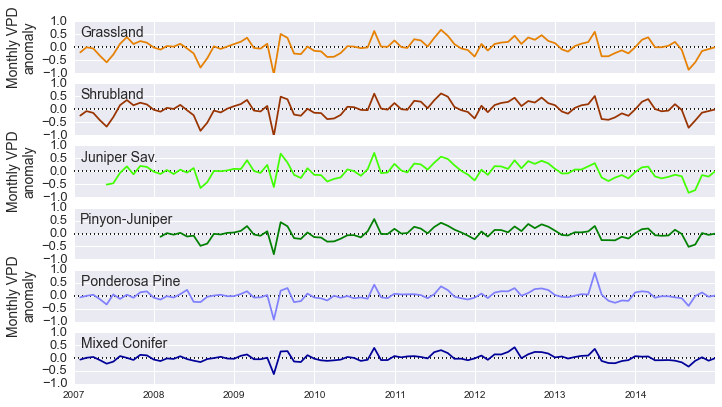

In [8]:
ylims = [ -1, 1 ]

fig3 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
fig3 = plot_tseries(fig3, anom_m, sites, 'VPD_F_max', 'Monthly VPD\nanomaly',
                   0.4, xlims, ylims)

fig3.savefig( fig_path + 'NMEG_monthly_vpdanom.svg')
fig3.savefig( fig_path + 'NMEG_monthly_vpdanom', dpi=200)

## Cumulative FC

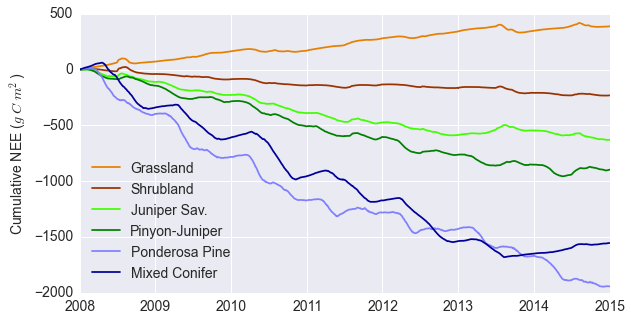

In [9]:
fig4 = plt.figure( figsize=( 9.5, 5 ), dpi=150, facecolor='w', edgecolor='k' )
var = 'FC_F_g_int'
ax = fig4.add_subplot(111)
idx = d.Seg.index.year > 2007
plt.plot( d.Seg[idx].index, d.Seg.loc[ idx, var ].cumsum(), color=nmeg_palette[0] )
idx = d.Ses.index.year > 2007
plt.plot( d.Ses[idx].index, d.Ses.loc[ idx, var ].cumsum(), color=nmeg_palette[1] )
idx = d.Wjs.index.year > 2007
plt.plot( d.Wjs[idx].index, d.Wjs.loc[ idx, var ].cumsum(), color=nmeg_palette[2] )
idx = d.Mpj.index.year > 2007
plt.plot( d.Mpj[idx].index, d.Mpj.loc[ idx, var ].cumsum(), color=nmeg_palette[3] )
idx = d.Vcp.index.year > 2007
plt.plot( d.Vcp[idx].index, d.Vcp.loc[ idx, var ].cumsum(), color=nmeg_palette[4] )
idx = np.logical_and( d.Vcm.index.year > 2007, d.Vcm.index.year < 2015 )
plt.plot( d.Vcm[idx].index, d.Vcm.loc[ idx, var ].cumsum(), color=nmeg_palette[5] )
plt.ylabel(r'Cumulative NEE ($g\ C\ m^2$)', fontsize=14)
plt.setp( ax.get_yticklabels(), fontsize=14)
plt.setp( ax.get_xticklabels(), fontsize=14)

plt.legend( nmeg_names, loc='lower left',
           fontsize=14)
plt.show()

fig4.savefig( fig_path + 'NMEG_allyr_cum_cflux.svg')
fig4.savefig( fig_path + 'NMEG_allyr_cum_cflux.png', dpi=200)

## Relationship between Ecosystem C uptake and VPD anomaly

                site  vpddays       cflux
2007       Grassland       96   50.751990
2008       Grassland       67   72.251188
2009       Grassland       89   91.281421
2010       Grassland       88    6.232553
2011       Grassland       93  110.462481
2012       Grassland      113   61.552232
2013       Grassland       54    6.637308
2014       Grassland       48   39.777750
2007       Shrubland       94  -38.466643
2008       Shrubland       66  -39.213777
2009       Shrubland       92  -46.696627
2010       Shrubland       81  -56.188394
2011       Shrubland       92    8.825761
2012       Shrubland      111  -29.753002
2013       Shrubland       53  -44.919679
2014       Shrubland       54  -22.863327
2008    Juniper Sav.      200 -111.501624
2009    Juniper Sav.      204 -114.925155
2010    Juniper Sav.      173 -164.191025
2011    Juniper Sav.      219  -82.287362
2012    Juniper Sav.      245 -112.745210
2014    Juniper Sav.      146  -83.109308
2008  Pinyon-Juniper      187 -143

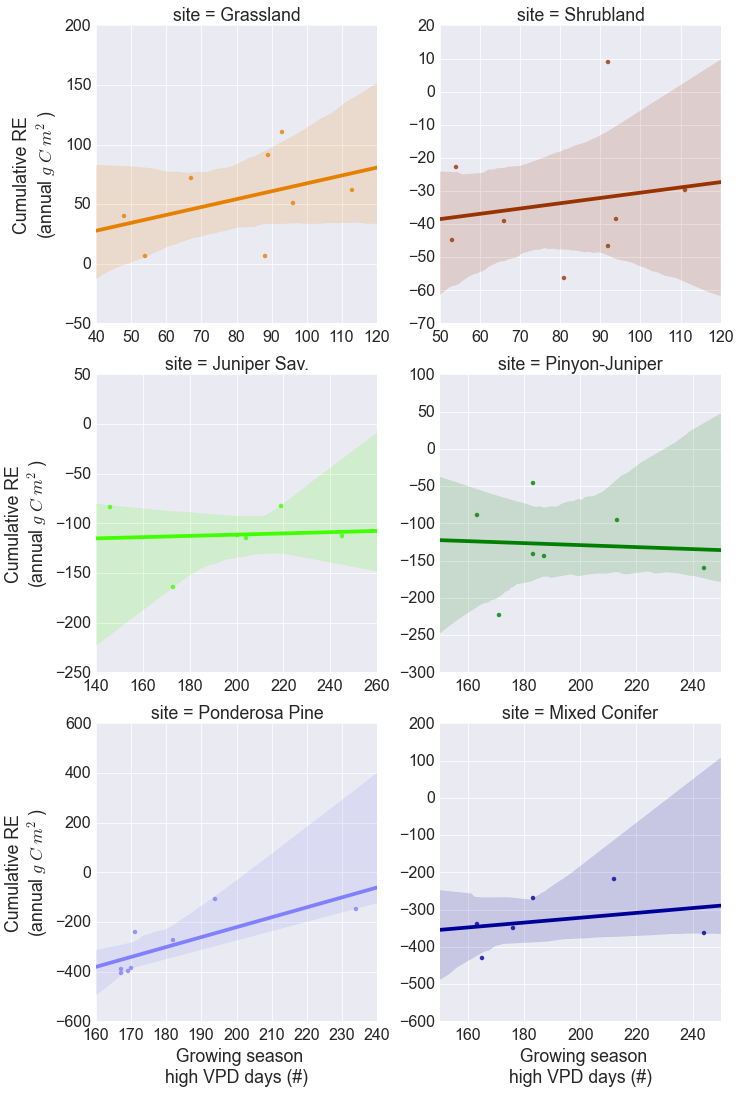

In [22]:

vpddays_cflux = pd.DataFrame()
fluxvar = 'FC_F_g_int'
figname = 'NMEG_ann_NEE_vpdanom.png'

#print(seg_vpdanom)

# Grassland

#Select the growing season
gs = np.logical_and(anom.Seg.index.month > 6, anom.Seg.index.month < 12)
vpd_sum = np.logical_and( anom.Seg.VPD_F_max > 0, gs );
vpd_sum = vpd_sum.resample('12MS', how='sum')
cflux_sum = d.Seg.resample('12MS', how='sum')
tidy = pd.DataFrame(index=vpd_sum.index.year)
tidy['site'] = 'Grassland'
tidy['vpddays'] = vpd_sum.values
tidy['cflux'] = cflux_sum[ fluxvar ].values
tidy = tidy[ np.logical_and(tidy.index < 2015, tidy.index > 2006) ]

vpddays_cflux = pd.concat( [vpddays_cflux, tidy], ignore_index=False )

# Shrubland
gs = np.logical_and(anom.Ses.index.month > 6, anom.Ses.index.month < 12)
vpd_sum = np.logical_and( anom.Ses.VPD_F_max > 0, gs );
vpd_sum = vpd_sum.resample('12MS', how='sum')
cflux_sum = d.Ses.resample('12MS', how='sum')
tidy = pd.DataFrame(index=vpd_sum.index.year)
tidy['site'] = 'Shrubland'
tidy['vpddays'] = vpd_sum.values
tidy['cflux'] = cflux_sum[ fluxvar ].values
tidy = tidy[ np.logical_and(tidy.index < 2015, tidy.index > 2006) ]

vpddays_cflux = pd.concat( [vpddays_cflux, tidy], ignore_index=False )

# JSav
vpd_sum = anom.Wjs.VPD_F_max > 0
vpd_sum = vpd_sum.resample('12MS', how='sum')
cflux_sum = d.Wjs.resample('12MS', how='sum')
tidy = pd.DataFrame(index=vpd_sum.index.year)
tidy['site'] = 'Juniper Sav.'
tidy['vpddays'] = vpd_sum.values
tidy['cflux'] = cflux_sum[ fluxvar ].values
tidy = tidy[ np.logical_and(tidy.index < 2015, np.logical_and( tidy.index > 2007, tidy.index != 2013 )) ]

vpddays_cflux = pd.concat( [vpddays_cflux, tidy], ignore_index=False )

# PJ
vpd_sum = anom.Mpj.VPD_F_max > 0
vpd_sum = vpd_sum.resample('12MS', how='sum')
cflux_sum = d.Mpj.resample('12MS', how='sum')
tidy = pd.DataFrame(index=vpd_sum.index.year)
tidy['site'] = 'Pinyon-Juniper'
tidy['vpddays'] = vpd_sum.values
tidy['cflux'] = cflux_sum[ fluxvar ].values
tidy = tidy[ np.logical_and(tidy.index < 2015, tidy.index > 2007) ]

vpddays_cflux = pd.concat( [vpddays_cflux, tidy], ignore_index=False )

# PPine
vpd_sum = anom.Vcp.VPD_F_max > 0
vpd_sum = vpd_sum.resample('12MS', how='sum')
cflux_sum = d.Vcp.resample('12MS', how='sum')
tidy = pd.DataFrame(index=vpd_sum.index.year)
tidy['site'] = 'Ponderosa Pine'
tidy['vpddays'] = vpd_sum.values
tidy['cflux'] = cflux_sum[ fluxvar ].values
tidy = tidy[ np.logical_and(tidy.index < 2015, tidy.index > 2006) ]

vpddays_cflux = pd.concat( [vpddays_cflux, tidy], ignore_index=False )

# MCon
#gs = np.logical_and(vcm_vpdanom.index.month > 2, vcm_vpdanom.index.month < 12)
vpd_sum = anom.Vcm.VPD_F_max > 0
vpd_sum = vpd_sum.resample('12MS', how='sum')
cflux_sum = d.Vcm.resample('12MS', how='sum')
tidy = pd.DataFrame(index=vpd_sum.index.year)
tidy['site'] = 'Mixed Conifer'
tidy['vpddays'] = vpd_sum.values
tidy['cflux'] = cflux_sum[ fluxvar ].values
tidy = tidy[ np.logical_and(tidy.index < 2013, tidy.index > 2006) ]

vpddays_cflux = pd.concat( [vpddays_cflux, tidy], ignore_index=False )

#tidy = pd.melt(tidy,  id_vars=['site'], value_vars=['vpddays','cflux'])

print(vpddays_cflux)

sns.set_context("paper", font_scale=2, rc={"lines.linewidth": 2.5})
fig5 = sns.lmplot( 'vpddays', 'cflux', vpddays_cflux, col='site', hue='site',
                  col_order=nmeg_names, hue_order=nmeg_names, col_wrap=2, 
           sharey=False, sharex=False, palette=nmeg_palette )
#fig4.set_titles(template='')
fig5.set_axis_labels(' Growing season\nhigh VPD days (#)', 'Cumulative RE\n(annual $g\ C\ m^2$)');

fig5.savefig( fig_path + figname, dpi=200)
print(nmeg_names)
#axes = fig5.axes
#for num, i in enumerate( axes ):
#    i.text(sites[num])

## Plot whatever

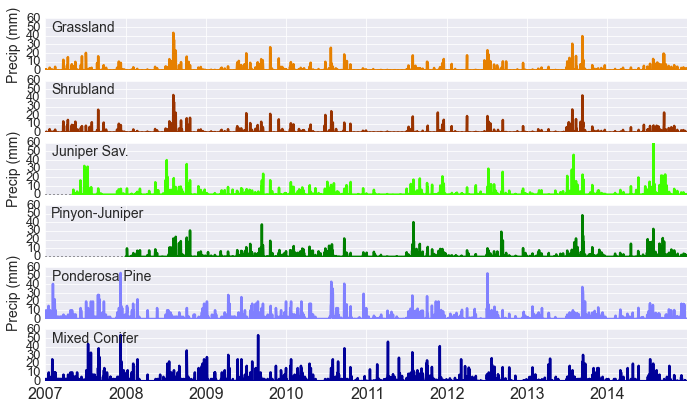

In [11]:
varname = 'P_F'
label = 'Precip (mm)'
ylims = [ 0, 60 ]
name_y = 45

figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
figX = plot_tseries(figX, d, sites, varname, label,
                   name_y, xlims, ylims)


figX.savefig( fig_path + 'NMEG_daily_PRECIP.png', dpi=200)